In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset
import os
import copy
from tensorboardX import SummaryWriter
from PIL import Image
import torchvision.transforms as transforms

plt.ion()   # interactive mode
%matplotlib inline

In [2]:
class KDEFDataset(Dataset):
    def __init__(self, root='D:\\Research\\data\\KDEF_and_AKDEF\\KDEF', transforms_=None, idx=[]):
        self.transform = transforms_
        self.files = []

        for path, subdirs, files in os.walk(root):
            for name in files:
                self.files.append(os.path.join(path, name))
        
        self.files =  [self.files[i] for i in idx]
        self.classes = {
             "AF":0,
             "AN":1,
             "DI":2,
             "HA":3,
             "NE":4,
             "SA":5,
             "SU":6
        }
        
        for index in range(4900):
            filepath = self.files[index % len(self.files)]
            filename = filepath.split('\\')[-1]
            if filename[4:6] not in self.classes:
                print(filepath)

    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]

        filename = filepath.split('\\')[-1]
        img = self.transform(Image.open(filepath))
        label = self.classes[filename[4:6]]

        return img, label

    def __len__(self):
        return len(self.files)

Load Data
---------


In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

idx = np.random.permutation(4900)
idx = {'val': idx[0:490], 'train': idx[490:]}

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=8,
                                             shuffle=True)
              for x in ['train', 'val']}

dataset_sizes = {x: len(idx[x]) for x in ['train', 'val']}
class_names = 7

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images


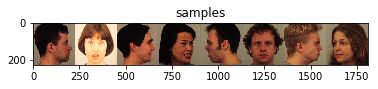

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='samples')

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [11]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, dataloaders, writer=None, i=0,  num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            writer.add_scalar(phase+"/loss", epoch_loss, epoch)
            writer.add_scalar(phase+"/acc", epoch_acc, epoch)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'saved/resnet152_lowlr_'+str(i)+'.pt')

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

Visualizing the model predictions

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [7]:
accuracies = []
index = list(np.random.permutation(4900))


for i in range(10):
    idx = {'val': index[490*i:490*(i+1)], 'train': index[:i*490]+index[((i+1)*490) -1:]}
 
    dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=idx[x]), batch_size=16,
                                             shuffle=True)
              for x in ['train', 'val']}

    model_ft = models.resnet152(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, class_names)

    model_ft = model_ft.to(device)
 
    criterion = nn.CrossEntropyLoss()

    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.1)
    writer = SummaryWriter('./logs/resnet152_kfold_'+str(i))

    model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                     dataloaders, writer, i, num_epochs=20)
    
    accuracies.append(float(best_acc.data[0].cpu().numpy()))
    print("\n\n\n------------------------------------\n Accuracies ", accuracies)
    print("\n\n")

Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 1.1287 Acc: 0.5621


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.5067 Acc: 0.7776

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.4115 Acc: 0.8569


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.3833 Acc: 0.8735

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.2444 Acc: 0.9181


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.31it/s]


val Loss: 0.2002 Acc: 0.9306

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1907 Acc: 0.9383


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.2137 Acc: 0.9306

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1262 Acc: 0.9585


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1784 Acc: 0.9306

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1066 Acc: 0.9658


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.2374 Acc: 0.9143

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0632 Acc: 0.9834


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.32it/s]


val Loss: 0.1102 Acc: 0.9551

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0429 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.0995 Acc: 0.9633

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0331 Acc: 0.9925


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1004 Acc: 0.9673

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0341 Acc: 0.9918


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.0967 Acc: 0.9653

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0259 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.0949 Acc: 0.9694

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0295 Acc: 0.9927


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.0935 Acc: 0.9653

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0233 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.0812 Acc: 0.9776

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0215 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.0864 Acc: 0.9776

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0217 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.0912 Acc: 0.9673

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0191 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.0833 Acc: 0.9735

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0252 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.0849 Acc: 0.9714

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0228 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.0968 Acc: 0.9694

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0218 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.0916 Acc: 0.9673

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0235 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.0638 Acc: 0.9837

Training complete in 65m 30s
Best val Acc: 0.983673


C:\Users\bikas\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number





------------------------------------
 Accuracies  [0.9836734693877552]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 1.1563 Acc: 0.5605


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.7627 Acc: 0.7490

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.4367 Acc: 0.8506


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.3119 Acc: 0.8918

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.2547 Acc: 0.9145


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.2721 Acc: 0.8980

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.1875 Acc: 0.9349


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.2070 Acc: 0.9224

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.1205 Acc: 0.9639


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.32it/s]


val Loss: 0.1788 Acc: 0.9408

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0939 Acc: 0.9689


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1789 Acc: 0.9306

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0516 Acc: 0.9875


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.16it/s]


val Loss: 0.1225 Acc: 0.9531

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0415 Acc: 0.9880


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1067 Acc: 0.9571

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0314 Acc: 0.9921


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1002 Acc: 0.9612

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0290 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1092 Acc: 0.9551

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0263 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.28it/s]


val Loss: 0.1307 Acc: 0.9571

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0247 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1092 Acc: 0.9571

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.0201 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1090 Acc: 0.9571

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0214 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1154 Acc: 0.9571

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0191 Acc: 0.9971


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1130 Acc: 0.9531

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0221 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1066 Acc: 0.9531

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.45it/s]


train Loss: 0.0220 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.13it/s]


val Loss: 0.1045 Acc: 0.9571

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0202 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.1308 Acc: 0.9510

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.43it/s]


train Loss: 0.0199 Acc: 0.9977


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1097 Acc: 0.9531

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0206 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1123 Acc: 0.9551

Training complete in 65m 53s
Best val Acc: 0.961224



------------------------------------
 Accuracies  [0.9836734693877552, 0.9612244897959185]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 1.0940 Acc: 0.5707


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.34it/s]


val Loss: 0.4896 Acc: 0.8286

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:06<00:00,  1.48it/s]


train Loss: 0.4123 Acc: 0.8556


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.4488 Acc: 0.8429

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.45it/s]


train Loss: 0.2663 Acc: 0.9150


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.11it/s]


val Loss: 0.2388 Acc: 0.9184

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.45it/s]


train Loss: 0.1916 Acc: 0.9376


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.3758 Acc: 0.8898

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.1285 Acc: 0.9580


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.2287 Acc: 0.9286

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0934 Acc: 0.9703


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1808 Acc: 0.9612

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.0521 Acc: 0.9855


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1666 Acc: 0.9571

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0423 Acc: 0.9884


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1720 Acc: 0.9551

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0297 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1666 Acc: 0.9612

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0269 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.30it/s]


val Loss: 0.1638 Acc: 0.9551

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0262 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1517 Acc: 0.9633

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0228 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1577 Acc: 0.9612

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0232 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.12it/s]


val Loss: 0.1623 Acc: 0.9612

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0269 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1536 Acc: 0.9633

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0211 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1516 Acc: 0.9612

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0223 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1561 Acc: 0.9592

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0249 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1593 Acc: 0.9653

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0208 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1542 Acc: 0.9612

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0226 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1526 Acc: 0.9653

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0237 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1608 Acc: 0.9592

Training complete in 66m 1s
Best val Acc: 0.965306



------------------------------------
 Accuracies  [0.9836734693877552, 0.9612244897959185, 0.9653061224489797]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 1.1070 Acc: 0.5728


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.5936 Acc: 0.7918

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.4375 Acc: 0.8456


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.3395 Acc: 0.8755

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.2557 Acc: 0.9104


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.2972 Acc: 0.8837

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.1685 Acc: 0.9449


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.2332 Acc: 0.9224

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.1296 Acc: 0.9580


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1927 Acc: 0.9449

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0934 Acc: 0.9671


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1844 Acc: 0.9429

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0571 Acc: 0.9844


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1576 Acc: 0.9531

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0399 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1505 Acc: 0.9571

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0317 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1452 Acc: 0.9571

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0316 Acc: 0.9923


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1240 Acc: 0.9633

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0296 Acc: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1387 Acc: 0.9571

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0263 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.1228 Acc: 0.9673

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0236 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1148 Acc: 0.9673

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0184 Acc: 0.9975


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1381 Acc: 0.9633

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0227 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1313 Acc: 0.9612

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0210 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1348 Acc: 0.9633

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0208 Acc: 0.9973


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1287 Acc: 0.9653

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0201 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1416 Acc: 0.9612

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:13<00:00,  1.43it/s]


train Loss: 0.0176 Acc: 0.9977


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:11<00:00,  2.77it/s]


val Loss: 0.1235 Acc: 0.9633

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:21<00:00,  1.37it/s]


train Loss: 0.0200 Acc: 0.9973


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1480 Acc: 0.9551

Training complete in 66m 15s
Best val Acc: 0.967347



------------------------------------
 Accuracies  [0.9836734693877552, 0.9612244897959185, 0.9653061224489797, 0.9673469387755103]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 1.0743 Acc: 0.5918


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.4856 Acc: 0.8143

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.4321 Acc: 0.8526


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.4076 Acc: 0.8551

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.2673 Acc: 0.9082


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.3445 Acc: 0.8694

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.1564 Acc: 0.9506


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.2150 Acc: 0.9082

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.1362 Acc: 0.9542


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.2022 Acc: 0.9204

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0882 Acc: 0.9723


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.2809 Acc: 0.9082

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0554 Acc: 0.9834


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1681 Acc: 0.9408

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0401 Acc: 0.9909


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1484 Acc: 0.9449

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0317 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1680 Acc: 0.9388

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0299 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1540 Acc: 0.9388

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0274 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1592 Acc: 0.9429

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0244 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1684 Acc: 0.9408

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0223 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1590 Acc: 0.9449

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.48it/s]


train Loss: 0.0197 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1534 Acc: 0.9408

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0236 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.27it/s]


val Loss: 0.1655 Acc: 0.9429

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0217 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1671 Acc: 0.9367

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0193 Acc: 0.9971


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1566 Acc: 0.9469

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0209 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1638 Acc: 0.9388

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0226 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1649 Acc: 0.9388

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0189 Acc: 0.9980


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.1612 Acc: 0.9408

Training complete in 65m 59s
Best val Acc: 0.946939



------------------------------------
 Accuracies  [0.9836734693877552, 0.9612244897959185, 0.9653061224489797, 0.9673469387755103, 0.9469387755102041]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 1.1291 Acc: 0.5592


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.5335 Acc: 0.8184

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.4430 Acc: 0.8420


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.2717 Acc: 0.9163

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.2456 Acc: 0.9168


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.15it/s]


val Loss: 0.2544 Acc: 0.9061

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.1616 Acc: 0.9456


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.2796 Acc: 0.9020

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.1268 Acc: 0.9585


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1821 Acc: 0.9327

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.1046 Acc: 0.9664


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.2046 Acc: 0.9265

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0488 Acc: 0.9878


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1309 Acc: 0.9449

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0404 Acc: 0.9873


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1448 Acc: 0.9469

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0333 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.1337 Acc: 0.9408

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0304 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.25it/s]


val Loss: 0.1336 Acc: 0.9510

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0296 Acc: 0.9934


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1255 Acc: 0.9531

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0208 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.22it/s]


val Loss: 0.1417 Acc: 0.9429

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.0251 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.01it/s]


val Loss: 0.1281 Acc: 0.9490

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0229 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.16it/s]


val Loss: 0.1344 Acc: 0.9388

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.45it/s]


train Loss: 0.0192 Acc: 0.9975


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.09it/s]


val Loss: 0.1423 Acc: 0.9449

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0242 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.09it/s]


val Loss: 0.1231 Acc: 0.9469

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0225 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.23it/s]


val Loss: 0.1338 Acc: 0.9408

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0263 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.05it/s]


val Loss: 0.1423 Acc: 0.9449

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0191 Acc: 0.9973


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.29it/s]


val Loss: 0.1330 Acc: 0.9449

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0220 Acc: 0.9971


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.08it/s]


val Loss: 0.1246 Acc: 0.9490

Training complete in 66m 18s
Best val Acc: 0.953061



------------------------------------
 Accuracies  [0.9836734693877552, 0.9612244897959185, 0.9653061224489797, 0.9673469387755103, 0.9469387755102041, 0.953061224489796]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:16<00:00,  1.40it/s]


train Loss: 1.1182 Acc: 0.5694


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.88it/s]


val Loss: 0.7234 Acc: 0.7224

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:20<00:00,  1.38it/s]


train Loss: 0.4284 Acc: 0.8492


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.96it/s]


val Loss: 0.4732 Acc: 0.8449

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:20<00:00,  1.37it/s]


train Loss: 0.2471 Acc: 0.9213


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.10it/s]


val Loss: 0.4243 Acc: 0.8837

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.44it/s]


train Loss: 0.1914 Acc: 0.9338


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.04it/s]


val Loss: 0.2455 Acc: 0.9143

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.43it/s]


train Loss: 0.1219 Acc: 0.9605


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.97it/s]


val Loss: 0.1937 Acc: 0.9408

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:22<00:00,  1.36it/s]


train Loss: 0.0962 Acc: 0.9723


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.99it/s]


val Loss: 0.1997 Acc: 0.9347

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:15<00:00,  1.41it/s]


train Loss: 0.0585 Acc: 0.9855


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.12it/s]


val Loss: 0.1587 Acc: 0.9531

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0406 Acc: 0.9893


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.85it/s]


val Loss: 0.1420 Acc: 0.9531

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.43it/s]


train Loss: 0.0344 Acc: 0.9916


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.07it/s]


val Loss: 0.1232 Acc: 0.9612

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0304 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.13it/s]


val Loss: 0.1187 Acc: 0.9571

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.0273 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.01it/s]


val Loss: 0.1437 Acc: 0.9571

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:13<00:00,  1.43it/s]


train Loss: 0.0259 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1431 Acc: 0.9531

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0211 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1156 Acc: 0.9633

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0252 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.07it/s]


val Loss: 0.1201 Acc: 0.9612

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0232 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.15it/s]


val Loss: 0.1279 Acc: 0.9571

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0217 Acc: 0.9975


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.10it/s]


val Loss: 0.1323 Acc: 0.9571

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:07<00:00,  1.47it/s]


train Loss: 0.0244 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.1258 Acc: 0.9592

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.0250 Acc: 0.9937


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.13it/s]


val Loss: 0.1266 Acc: 0.9633

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.0214 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.10it/s]


val Loss: 0.1344 Acc: 0.9592

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0229 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.10it/s]


val Loss: 0.1239 Acc: 0.9592

Training complete in 67m 40s
Best val Acc: 0.963265



------------------------------------
 Accuracies  [0.9836734693877552, 0.9612244897959185, 0.9653061224489797, 0.9673469387755103, 0.9469387755102041, 0.953061224489796, 0.9632653061224491]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 1.1097 Acc: 0.5846


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.12it/s]


val Loss: 0.5186 Acc: 0.8061

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.3956 Acc: 0.8642


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.12it/s]


val Loss: 0.3783 Acc: 0.8694

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.2641 Acc: 0.9102


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.15it/s]


val Loss: 0.2790 Acc: 0.8939

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.1666 Acc: 0.9454


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.4071 Acc: 0.8796

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.1152 Acc: 0.9639


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.2853 Acc: 0.9082

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.45it/s]


train Loss: 0.1146 Acc: 0.9605


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.10it/s]


val Loss: 0.1932 Acc: 0.9367

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.46it/s]


train Loss: 0.0549 Acc: 0.9868


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.08it/s]


val Loss: 0.1805 Acc: 0.9408

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0412 Acc: 0.9900


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.16it/s]


val Loss: 0.1829 Acc: 0.9388

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0329 Acc: 0.9930


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.13it/s]


val Loss: 0.1656 Acc: 0.9327

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0285 Acc: 0.9932


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.14it/s]


val Loss: 0.1613 Acc: 0.9388

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0246 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.04it/s]


val Loss: 0.1570 Acc: 0.9388

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:09<00:00,  1.45it/s]


train Loss: 0.0214 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1805 Acc: 0.9327

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0246 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.13it/s]


val Loss: 0.1560 Acc: 0.9408

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0211 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.12it/s]


val Loss: 0.1657 Acc: 0.9388

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0225 Acc: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.12it/s]


val Loss: 0.1651 Acc: 0.9388

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0193 Acc: 0.9968


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.16it/s]


val Loss: 0.1607 Acc: 0.9408

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0250 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.1638 Acc: 0.9347

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0190 Acc: 0.9980


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1636 Acc: 0.9408

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0209 Acc: 0.9971


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.10it/s]


val Loss: 0.1643 Acc: 0.9367

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0207 Acc: 0.9961


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.14it/s]


val Loss: 0.1661 Acc: 0.9367

Training complete in 66m 46s
Best val Acc: 0.940816



------------------------------------
 Accuracies  [0.9836734693877552, 0.9612244897959185, 0.9653061224489797, 0.9673469387755103, 0.9469387755102041, 0.953061224489796, 0.9632653061224491, 0.9408163265306123]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 1.1124 Acc: 0.5776


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.15it/s]


val Loss: 0.4647 Acc: 0.8224

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.4239 Acc: 0.8497


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.05it/s]


val Loss: 0.2997 Acc: 0.9000

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.2666 Acc: 0.9068


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.14it/s]


val Loss: 0.2594 Acc: 0.9000

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.1681 Acc: 0.9469


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.11it/s]


val Loss: 0.2904 Acc: 0.8918

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.1518 Acc: 0.9497


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.12it/s]


val Loss: 0.3082 Acc: 0.9061

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.44it/s]


train Loss: 0.1221 Acc: 0.9601


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.06it/s]


val Loss: 0.1811 Acc: 0.9327

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0632 Acc: 0.9846


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.09it/s]


val Loss: 0.1339 Acc: 0.9531

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0446 Acc: 0.9896


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.17it/s]


val Loss: 0.0992 Acc: 0.9673

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0307 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.08it/s]


val Loss: 0.1184 Acc: 0.9551

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0326 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.13it/s]


val Loss: 0.0841 Acc: 0.9673

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.44it/s]


train Loss: 0.0285 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.16it/s]


val Loss: 0.0768 Acc: 0.9714

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0249 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.16it/s]


val Loss: 0.0810 Acc: 0.9633

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0235 Acc: 0.9955


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1000 Acc: 0.9673

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0261 Acc: 0.9964


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.16it/s]


val Loss: 0.1142 Acc: 0.9592

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0268 Acc: 0.9946


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.08it/s]


val Loss: 0.0722 Acc: 0.9694

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0218 Acc: 0.9971


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.10it/s]


val Loss: 0.1074 Acc: 0.9612

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.44it/s]


train Loss: 0.0241 Acc: 0.9957


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.02it/s]


val Loss: 0.0967 Acc: 0.9673

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.43it/s]


train Loss: 0.0259 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.03it/s]


val Loss: 0.1016 Acc: 0.9633

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.43it/s]


train Loss: 0.0227 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.03it/s]


val Loss: 0.1021 Acc: 0.9673

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.44it/s]


train Loss: 0.0255 Acc: 0.9943


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.08it/s]


val Loss: 0.1004 Acc: 0.9653

Training complete in 67m 17s
Best val Acc: 0.971429



------------------------------------
 Accuracies  [0.9836734693877552, 0.9612244897959185, 0.9653061224489797, 0.9673469387755103, 0.9469387755102041, 0.953061224489796, 0.9632653061224491, 0.9408163265306123, 0.9714285714285715]



Epoch 0/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:15<00:00,  1.41it/s]


train Loss: 1.1344 Acc: 0.5662


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.03it/s]


val Loss: 0.4841 Acc: 0.8143

Epoch 1/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:14<00:00,  1.42it/s]


train Loss: 0.4174 Acc: 0.8499


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.06it/s]


val Loss: 0.3989 Acc: 0.8612

Epoch 2/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:13<00:00,  1.43it/s]


train Loss: 0.2473 Acc: 0.9177


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.07it/s]


val Loss: 0.3461 Acc: 0.8694

Epoch 3/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:13<00:00,  1.43it/s]


train Loss: 0.1797 Acc: 0.9415


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.12it/s]


val Loss: 0.3257 Acc: 0.8898

Epoch 4/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.1356 Acc: 0.9549


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.08it/s]


val Loss: 0.2720 Acc: 0.9184

Epoch 5/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0906 Acc: 0.9723


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.13it/s]


val Loss: 0.2367 Acc: 0.9224

Epoch 6/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0649 Acc: 0.9816


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.98it/s]


val Loss: 0.1643 Acc: 0.9347

Epoch 7/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.44it/s]


train Loss: 0.0424 Acc: 0.9902


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.83it/s]


val Loss: 0.1556 Acc: 0.9408

Epoch 8/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:18<00:00,  1.39it/s]


train Loss: 0.0330 Acc: 0.9914


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.00it/s]


val Loss: 0.1347 Acc: 0.9429

Epoch 9/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:14<00:00,  1.42it/s]


train Loss: 0.0368 Acc: 0.9912


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  2.88it/s]


val Loss: 0.1052 Acc: 0.9633

Epoch 10/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.43it/s]


train Loss: 0.0251 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:10<00:00,  3.08it/s]


val Loss: 0.1308 Acc: 0.9551

Epoch 11/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0209 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1262 Acc: 0.9510

Epoch 12/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0232 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.11it/s]


val Loss: 0.1320 Acc: 0.9531

Epoch 13/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:18<00:00,  1.39it/s]


train Loss: 0.0254 Acc: 0.9950


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.21it/s]


val Loss: 0.1272 Acc: 0.9510

Epoch 14/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:12<00:00,  1.43it/s]


train Loss: 0.0245 Acc: 0.9939


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.19it/s]


val Loss: 0.1261 Acc: 0.9510

Epoch 15/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0207 Acc: 0.9971


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.15it/s]


val Loss: 0.1053 Acc: 0.9653

Epoch 16/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.46it/s]


train Loss: 0.0237 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


val Loss: 0.1156 Acc: 0.9571

Epoch 17/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:08<00:00,  1.47it/s]


train Loss: 0.0209 Acc: 0.9966


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.26it/s]


val Loss: 0.1300 Acc: 0.9490

Epoch 18/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:10<00:00,  1.45it/s]


train Loss: 0.0234 Acc: 0.9948


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


val Loss: 0.1316 Acc: 0.9449

Epoch 19/19
----------


100%|████████████████████████████████████████████████████████████████████████████████| 276/276 [03:11<00:00,  1.44it/s]


train Loss: 0.0227 Acc: 0.9952


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.18it/s]


val Loss: 0.1380 Acc: 0.9469

Training complete in 67m 35s
Best val Acc: 0.965306



------------------------------------
 Accuracies  [0.9836734693877552, 0.9612244897959185, 0.9653061224489797, 0.9673469387755103, 0.9469387755102041, 0.953061224489796, 0.9632653061224491, 0.9408163265306123, 0.9714285714285715, 0.9653061224489797]





# Load and test the model

In [8]:
model_ft.load_state_dict(torch.load('saved/resnet152_0.pt'))
model_ft.eval()

dataloaders = {x: torch.utils.data.DataLoader(KDEFDataset(transforms_=data_transforms[x], idx=index), batch_size=1,
                                             shuffle=True)
              for x in ['train', 'val']}

In [9]:
import imageio
total = 0
correct = 0

classes = {
    0 : "AF",
    1 : "AN",
    2 : "DI",
    3 : "HA",
    4 : "NE",
    5 : "SA",
    6 : "SU"
}

for inputs, labels in tqdm(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    
    total+=1
    if labels.data[0].cpu().numpy() == preds.data[0].cpu().numpy():
        correct+=1
    else:
        # save the image
        img = inputs[0].cpu().numpy()
        img = np.ascontiguousarray(img.transpose(1,2,0))
        imageio.imwrite(str(total)+'.jpg', img)
        
        print("image no ", str(total), "  original class : ", classes[int(labels.data[0].cpu().numpy())], "  predicted class: ", classes[int(preds.data[0].cpu().numpy())])

print(correct, total)

  4%|██▉                                                                            | 186/4900 [00:06<02:57, 26.61it/s]

image no  189   original class :  NE   predicted class:  DI


  4%|███▍                                                                           | 213/4900 [00:08<02:56, 26.56it/s]

image no  215   original class :  AN   predicted class:  DI


  5%|███▊                                                                           | 234/4900 [00:08<02:55, 26.61it/s]

image no  235   original class :  AF   predicted class:  SU


 10%|████████                                                                       | 501/4900 [00:18<02:45, 26.55it/s]

image no  504   original class :  NE   predicted class:  SA


 16%|████████████▋                                                                  | 788/4900 [00:29<02:36, 26.33it/s]

image no  790   original class :  NE   predicted class:  DI


 19%|██████████████▊                                                                | 915/4900 [00:34<02:31, 26.28it/s]

image no  917   original class :  SA   predicted class:  AF


 21%|████████████████▌                                                             | 1040/4900 [00:39<02:26, 26.27it/s]

image no  1043   original class :  NE   predicted class:  SA


 24%|███████████████████                                                           | 1199/4900 [00:45<02:21, 26.23it/s]

image no  1200   original class :  AF   predicted class:  SU


 26%|████████████████████                                                          | 1260/4900 [00:48<02:18, 26.23it/s]

image no  1262   original class :  DI   predicted class:  SA


 38%|█████████████████████████████▎                                                | 1841/4900 [01:10<01:56, 26.24it/s]

image no  1844   original class :  AF   predicted class:  DI


 53%|█████████████████████████████████████████▍                                    | 2605/4900 [01:38<01:26, 26.41it/s]

image no  2607   original class :  SU   predicted class:  DI


 59%|██████████████████████████████████████████████▎                               | 2912/4900 [01:50<01:15, 26.45it/s]

image no  2914   original class :  NE   predicted class:  SA


 64%|█████████████████████████████████████████████████▉                            | 3138/4900 [01:58<01:06, 26.49it/s]

image no  3140   original class :  SA   predicted class:  AF


 69%|█████████████████████████████████████████████████████▊                        | 3382/4900 [02:07<00:57, 26.50it/s]

image no  3385   original class :  AF   predicted class:  SA


 76%|██████████████████████████████████████████████████████████▉                   | 3700/4900 [02:19<00:45, 26.53it/s]

image no  3703   original class :  AF   predicted class:  SU


 79%|█████████████████████████████████████████████████████████████▍                | 3860/4900 [02:25<00:39, 26.52it/s]

image no  3863   original class :  AN   predicted class:  DI


 81%|███████████████████████████████████████████████████████████████               | 3964/4900 [02:29<00:35, 26.52it/s]

image no  3966   original class :  NE   predicted class:  SA


 93%|████████████████████████████████████████████████████████████████████████▍     | 4554/4900 [02:52<00:13, 26.39it/s]

image no  4556   original class :  AF   predicted class:  AN


100%|██████████████████████████████████████████████████████████████████████████████| 4900/4900 [03:06<00:00, 26.33it/s]


4882 4900


# Low LR experiemnt